## Import Data

In [1]:
#Import all the libraries that are needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import itertools
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from fastai.text import *

In [2]:
#import files & store as dataframe
df = pd.read_csv("Tweets.csv", low_memory = False)

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Now we check if there are any nulls in the dataframe. We observe that there are 5462 nulls in negative_reason column. This nulls belong to positive + Neutral sentiments which makes sense. We verify this by taking count of all non-negative tweets. Both the numbers match. The reason negativereason_confidence count doesn't match with negativereason count is that the 0 values in negativereason_confidence column corresponds to blanks in negativereason column.

If we look at the total count of data samples, it's 14640. The columns airline_sentiment_gold, negativereason_gold & tweet_coord have large amounts of blanks, i.e. in the range of 13000-14000. Thus it can be concluded that these columns will not provide any significant information & thus can be discarded.

In [3]:
print(df.isnull().sum())
pos_sum = df[df['airline_sentiment']=='positive']
neu_sum = df[df['airline_sentiment']=='neutral']
neg_sum = df[df['airline_sentiment']=='negative']
zero_sum = df[df['negativereason_confidence']==0]
print('------------------------------------------------------')
print('total_non_neg = ',len(pos_sum)+len(neu_sum))
print('total zeros in neg_confidence = ',len(zero_sum))
print('------------------------------------------------------')
print('total_rows = ',len(pos_sum)+len(neu_sum)+len(neg_sum)) 

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64
------------------------------------------------------
total_non_neg =  5462
total zeros in neg_confidence =  1344
------------------------------------------------------
total_rows =  14640


In [4]:
df_new = df.drop(['airline_sentiment_gold', 'negativereason_gold','tweet_coord'], axis = 1)
df_new.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Exploratory analysis

Firstly, we will examine the overall sentiment of people of twitter towards U.S. airlines.

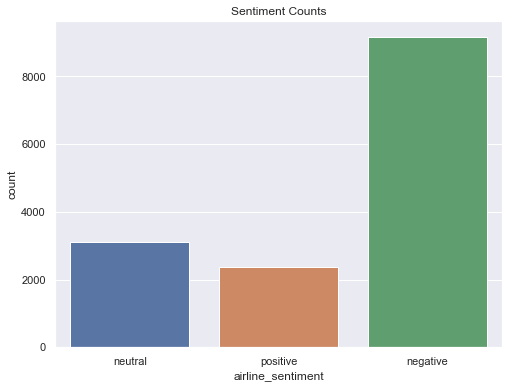

In [5]:
from matplotlib import pyplot
a4_dims = (8, 6)
sns.set(style="darkgrid")
fig, ax = pyplot.subplots(figsize=a4_dims)
plt.title('Sentiment Counts');
sns.countplot(df_new['airline_sentiment'],ax=ax);

It's evident from the count-plot that mostly the sentiment is negative, followed by neutral. Positive sentiment is the least to be seen.


Now we will compare the airlines based on number of tweets directed towards them.

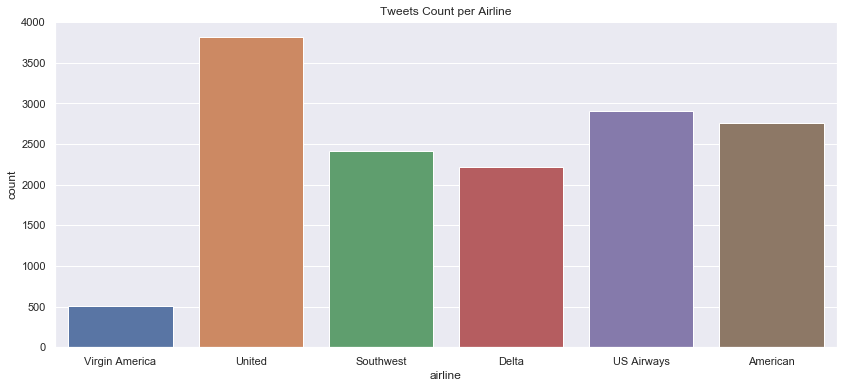

In [6]:
a4_dims = (14, 6)
figs, ax = pyplot.subplots(figsize=a4_dims)
plt.title('Tweets Count per Airline');
sns.countplot(df_new['airline'],ax=ax);

We see that the Virgin America has the least amount of tweets while United has the most. We can say that the United is used more often by folks while Virgin America isn't.

After examining the popularity of airlines among twitter folk, we will now compare airline based on the individual sentiments. For this, first we will segregate tweet count for each sentiment of every airline. Then we will calculate what % of total tweets does each sentiment represents. Finally, we will plot the results.   

In [7]:
df_senti = df_new.groupby(['airline','airline_sentiment'], sort=True).size().reset_index(name='Count')
a = list(df_new.groupby('airline', sort=True)['airline_sentiment'].count())
b = list(itertools.chain.from_iterable(itertools.repeat(x, 3) for x in a))
df_senti['total'] = b
df_senti['% of Total'] = round((df_senti['Count']/df_senti['total'])*100,2)
df_senti

,airline,airline_sentiment,Count,total,% of Total
0,American,negative,1960,2759,71.04
1,American,neutral,463,2759,16.78
2,American,positive,336,2759,12.18
3,Delta,negative,955,2222,42.98
4,Delta,neutral,723,2222,32.54
5,Delta,positive,544,2222,24.48
6,Southwest,negative,1186,2420,49.01
7,Southwest,neutral,664,2420,27.44
8,Southwest,positive,570,2420,23.55
9,US Airways,negative,2263,2913,77.69


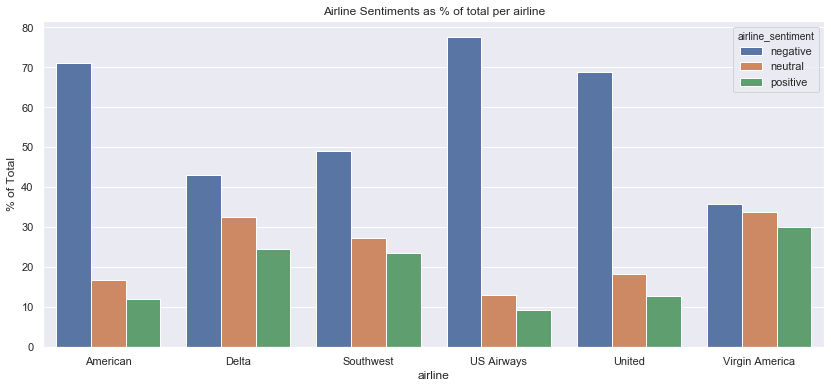

In [8]:
a4_dims = (14, 6)
figs, ax = pyplot.subplots(figsize=a4_dims)
plt.title('Airline Sentiments as % of total per airline');
sns.barplot(x="airline", y="% of Total", hue="airline_sentiment", data=df_senti,ax=ax);

Based on the plot, we can see that most of the tweets for American, US Airways & United are negative ~70%. Thus the outlook of folks towards these airlines is negative. For all the airlines, negative tweets are greater in number, followed by neutral than the positive. Virgin America is the only airline which has almost equal % of tweets for all the three sentiments. Thus it's safe to say that Virgin America is doing relatively better than the most. 

Now we will see what are the most used words in negative, neutral & positive tweets. For that first we will clean the text data using Regual Expression & then use wordcloud for visualization.

In [9]:
#extract text column as a list
text =  df_new.iloc[:,8]

#This function removes html chars, URLs & punctuation marks & does lowercasing.
def preprocess_tweets(tweets):
    processed_features = []
    for sentence in range(0, len(tweets)):
        processed_feature = re.sub('http\S+\s*', '',str(tweets[sentence]))          
        processed_feature = re.sub(r'\W', ' ', processed_feature ) #
        processed_feature = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
        processed_feature = re.sub(r'^b\s+', '', processed_feature)
        processed_feature = processed_feature.lower()
        processed_features.append(processed_feature)
    return processed_features

text_clean = preprocess_tweets(text)

print(text[0])
print('====================')
print(text_clean[0])

@VirginAmerica What @dhepburn said.
 virginamerica what  dhepburn said 


We can see the before & after effect of text cleaning

In [10]:
df_new['clean text'] = text_clean
neg = df_new[df_new['airline_sentiment']=='negative'].iloc[:,12]
neu = df_new[df_new['airline_sentiment']=='neutral'].iloc[:,12]
pos = df_new[df_new['airline_sentiment']=='positive'].iloc[:,12]

words_neg = ' '.join(neg)
words_neu = ' '.join(neu)
words_pos = ' '.join(pos)

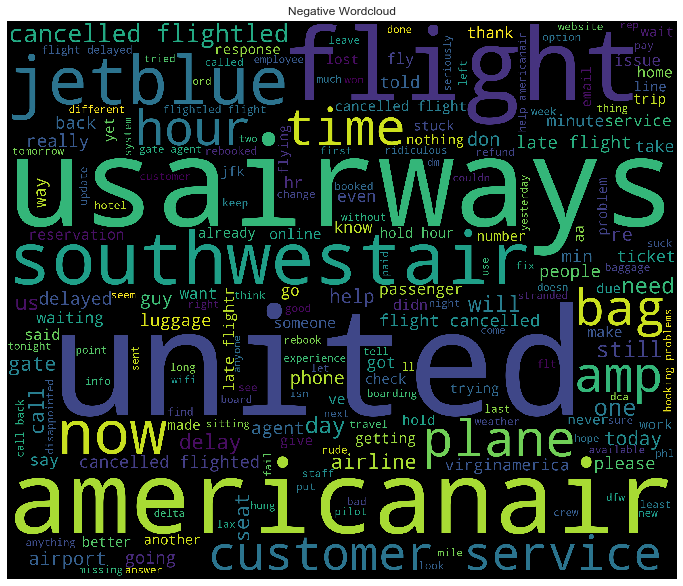

In [11]:
wordcloud_neg = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(words_neg)
plt.figure(1,figsize=(12, 12))
plt.title('Negative Wordcloud');
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.show()

From word cloud of negative tweets we see that most used words are: American air, US airways, southwest air, United, customer service, hour, time, cancalled flight, delayed. Most of these words denote flights & reason for negative comments.

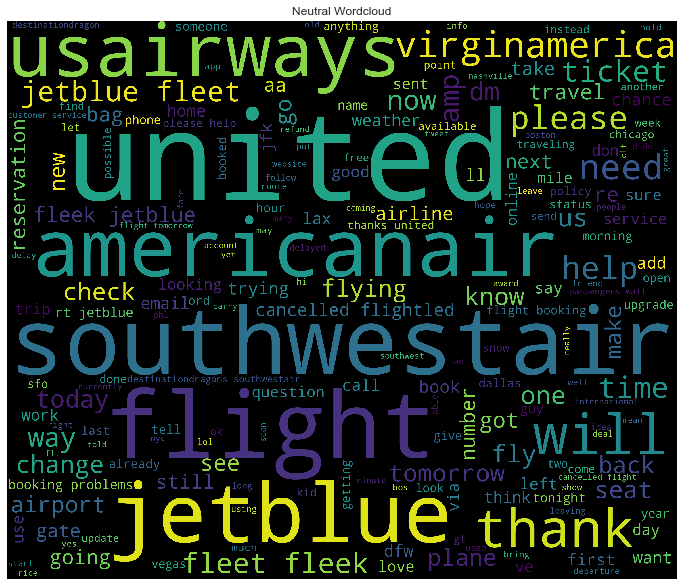

In [12]:
wordcloud_neu = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(words_neu)
plt.figure(1,figsize=(12, 12))
plt.title('Neutral Wordcloud');
plt.imshow(wordcloud_neu)
plt.axis('off')
plt.show()

From word cloud of neutral tweets we see that most used words are: American air, US airways, southwest air, United, customer reservation, please, time, cancalled flight. Most of these words denote flights & neutral tone. Though words like cancelled & please have negative conotation. From this we can say that there might be possibility that some of these tweets have been falsely sorted as neutral tweets.

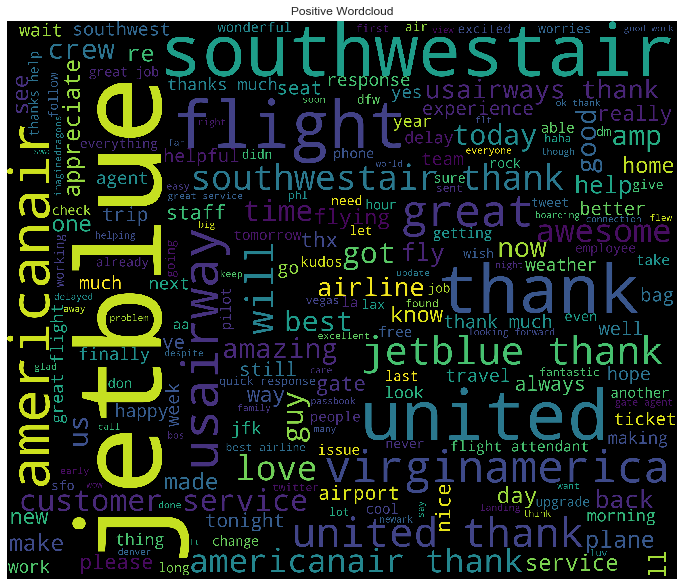

In [13]:
wordcloud_pos = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(words_pos)
plt.figure(1,figsize=(12, 12))
plt.title('Positive Wordcloud');
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.show()

From word cloud of positive tweets we see that most used words are: Virgin America, southwest air, United, thank, love. Most of these words denote flights & reason for positive comments.

Finally, we need to compare the reason of negative tweets.

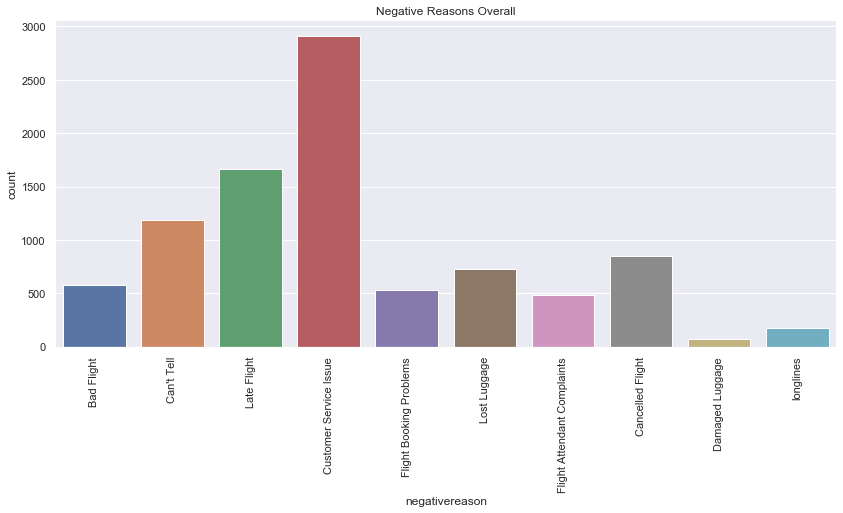

In [14]:
df_neg = df_new[df_new['airline_sentiment']=='negative']

a4_dims = (14, 6)
figs, ax = pyplot.subplots(figsize=a4_dims)
g = sns.countplot(x="negativereason", data=df_neg,ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=90);
plt.title('Negative Reasons Overall');

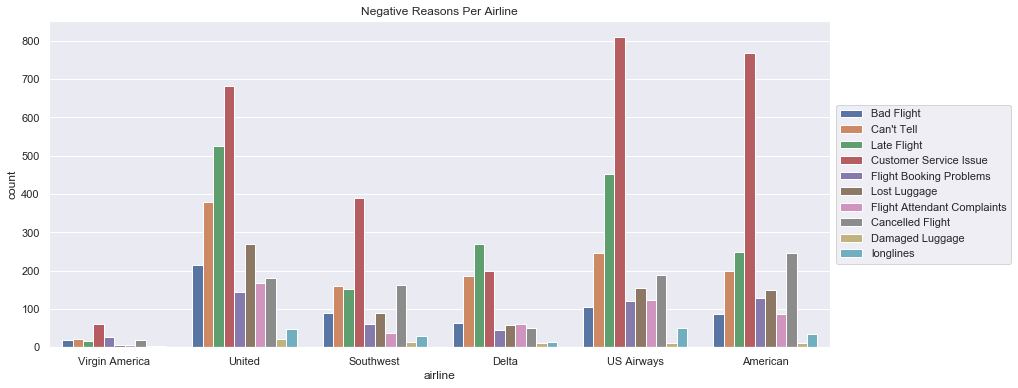

In [15]:
a4_dims = (14, 6)
figs, ax = pyplot.subplots(figsize=a4_dims)
g = sns.countplot(x="airline", hue="negativereason", data=df_neg,ax=ax)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Negative Reasons Per Airline');
plt.show()

We see that for almost all the airlines, Customer Service Issue was the primary reason for the negative comments except for the Delta Airline. 

## Language Model 

In [16]:
#This is the path to the directory where you have put your Tweets.csv file. In order to run code, please edit this path
path = 'C:/Users/sai/Desktop/Fellowship.AI'

When we are making NLP model with Fastai, there are two stages:

* Creating LM Model & fine tuning it with the pretrained model
* Using the fine-tuned model as a classifier

Here I'm using TextList which is part of the data bloc instead of using the factory methods of TextClasDataBunch and TextLMDataBunch because TextList is part of the API which is more flexible and powerful.

In [17]:
data_lm = (TextList
           .from_csv(path, 'Tweets.csv', cols='text')
           #Where are the text? Column 'text' of tweets.csv
           .split_by_rand_pct(0.2)
           #How to split it? Randomly with the default 20% in valid
           .label_for_lm()
           #Label it for a language model
           .databunch(bs=48))
           #Finally we convert to a DataBunch


In [18]:
data_lm.show_batch()

idx,text
0,"about it xxbos @virginamerica yes , nearly every time i fly xxup vx this “ xxunk xxunk ” wo n’t go away :) xxbos @virginamerica xxmaj really missed a prime opportunity for xxmaj xxunk xxmaj without xxmaj hats xxunk , there . https : / / t.co / xxunk xxbos @virginamerica xxmaj well , i xxunk … but xxup now i xxup do ! xxup xxunk xxbos @virginamerica it was"
1,": / / t.co / xxunk xxbos @virginamerica xxmaj applied for xxmaj status xxmaj match on xxmaj feb 1 . xxmaj got confirmation email same day . xxmaj still no news though . xxmaj you guys have dropped ball xxmaj late xxmaj flightly 😥 xxbos @virginamerica is my new go to airline xxbos @virginamerica i xxunk you , and am so looking forward to my flight to xxmaj austin in"
2,now i 'm leaving for a week . xxmaj this is why you were supposed to hold on to the bag xxrep 4 . xxbos @united i did xxup dm the details but still no response . i have to book today . xxbos @united i know this is probably a no but is there a way to get a cheaper airfare ticket if the flight is leaving in a
3,"i tweet the xxup id number , wo n't that xxunk my home address to anyone on the web ? xxbos @united i filed a delayed bag report on xxmaj saturday ! my flight was xxmaj cancelled xxmaj flightled and i never went anywhere ! xxbos @united the person is currently xxunk gates xxup xxunk and 73 in xxup lax xxbos @united i need it there before she lands so"
4,"or so a go . \n j xxbos @united you xxmaj cancelled xxmaj flight my flight . i wait in line to get rebooked , when i 'm at the front you make me go to another gate and i lose my place . xxbos @united it was n't a comment . xxmaj it was a question . xxmaj but thanks for your copy and paste response xxbos @united"


We can see that since we are training a language model, all the texts are concatenated together (with a random shuffle between them at each new epoch).

## Finetune pretrained model

Now we will fine-tune our model with with the weights of a model pretrained on a larger corpus, Wikitext 103. This model has been trained to predict the next word in the sentence provided to it as an input. 

As the language of the tweets is not always grammatically perfect, we will have to adjust the parameters to out model. 

In [23]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

Now it's time to find the optimal learning rate & visualize it. The visualization will help us to spot the range of learning rates & choose from while training our model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


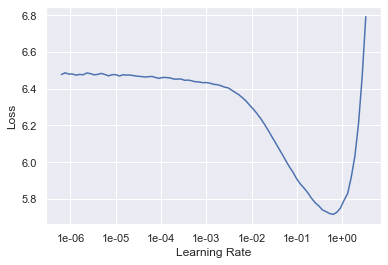

In [24]:
learn.lr_find();
learn.recorder.plot();

By default, the Learner object is frozen thus we need to train the embeddings at first. Here, instead of running the cycle for one epoch, I am going to run it for 6 to see how accuracy varies. The learning rate I picked is with the help of plot we got above.

In [25]:
learn.fit_one_cycle(6,5e-2, moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy,time
0,4.483931,3.912891,0.257454,12:16
1,4.050222,3.938859,0.254870,15:41
2,3.810489,3.890889,0.261350,15:28
3,3.549612,3.825631,0.269535,13:03
4,3.260542,3.789899,0.278463,12:23
5,3.043051,3.788641,0.279789,11:43


We got very low accuracy, which was expected rest of our model is still frozen but we can see that the accuracy is increasing. I am saving the model after each stage so that we can load it later without having to perform previous stages.

In [26]:
learn.save('fit_head')
learn.load('fit_head');

Now it's time to unfreeze the rest of the mode & perform the similar operations.

In [27]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.995475,3.792553,0.280817,23:24
1,3.093051,3.818181,0.279153,27:00
2,3.102600,3.810720,0.277746,27:20
3,2.969638,3.833411,0.278801,27:45
4,2.705206,3.942375,0.277246,30:23
5,2.316897,4.087634,0.277882,32:16
6,1.820545,4.309408,0.274554,27:05
7,1.352662,4.524722,0.272240,27:50
8,1.024878,4.649777,0.271753,26:15
9,0.879547,4.691885,0.271780,21:28


We see that the accuracy improved slightly but still looming in the same range. This is because firstly the model was trained on pretained model with different vocabulary & secondely, there were no labels, we had passed the data without specifying the labels.

In [28]:
learn.save('fine_tuned')

In [30]:
learn.load('fine_tuned');

Now we will test our model with random input & see if it'll accurately complete the sentence. 

In [31]:
TEXT = "The flight got delayed"
N_WORDS = 40
N_SENTENCES = 2

In [32]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The flight got delayed 2 hours . LAS to JAX is affected by weather . 
  WTF does this delay work ? xxbos @southwestair Ca n't update my flight online bc it 's been Cancelled Flighted twice already
The flight got delayed 2 days due to lavatory issues . BOS to ORD . Please have someone call me ASAP . xxbos @united i 'm on UA ... and my connecting flight is delayed too ! Please


We see that the model did fair job. The model used vocab related to flights, travel & urban language used on twitter but it's not cohesive.

In [33]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels.

In [53]:
data_clas = (TextList.from_csv(path, 'Tweets.csv', cols='text')
             #Where are the text? Column 'text' of tweets.csv
             .split_by_rand_pct(0.2)
             #How to split it? Randomly with the default 20% in valid
             .label_from_df(cols='airline_sentiment')
             #specify the label column
             .databunch(bs=48))
             #Create databunch
             

In [54]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @united xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,negative
xxbos @usairways xxup xxunk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup xxunk xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup xxunk u xxup and,negative
"xxbos @united xxmaj hi , i m flying xxup sfo - xxup lax - xxup xxunk - xxup xxunk . xxmaj my connecting time in xxup lax is xxunk m . xxmaj is it enough time ? xxmaj do i have to xxunk my bag and xxunk on xxup xxunk ?",neutral
xxbos @united xxup fail xxmaj you xxmaj cancelled xxmaj flightled our flight frm xxup xxunk and then used our reserv home to xxup iah ( from xxup sea ) for reflight xxmaj booking xxmaj problems w / out xxup our xxup xxunk ! ! # xxup xxunk,negative


The classifier needs a little less dropout, so we pass drop_mult=0.5 to multiply all the dropouts by this amount. We don't load the pretrained model, but instead our fine-tuned encoder from the previous section.

In [62]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11712 items)
x: TextList
xxbos @virginamerica plus you 've added commercials to the experience ... xxunk .,xxbos @virginamerica it 's really xxunk to xxunk xxunk " entertainment " in your xxunk ' xxunk & & they have little recourse,xxbos @virginamerica and it 's a really big bad thing about it,xxbos @virginamerica seriously would pay $ 30 a flight for seats that did n't have this playing . 
  it 's really the only bad thing about flying xxup va,xxbos @virginamerica yes , nearly every time i fly xxup vx this “ xxunk xxunk ” wo n’t go away :)
y: CategoryList
positive,negative,negative,negative,positive
Path: C:\Users\sai\Desktop\Fellowship.AI;

Valid: LabelList (2928 items)
x: TextList
xxbos @usairways xxunk 40 xxmaj boston xxunk fliers ... someone in management needs to # xxunk and # xxunk,xxbos @virginamerica @ladygaga @carrieunderwood xxmaj after last night # xxunk # xxunk # xxmaj oscars2015 @ladygaga ! i think @carrieunderwood agr

Again we perform the similar steps as Language mode. Here I am skipping the last 15 data points as I'm only interested till  1e-1.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


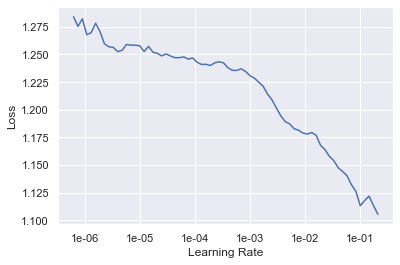

In [64]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [67]:
learn.fit_one_cycle(4, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.833410,0.821791,0.672131,06:15
1,0.825161,0.817405,0.651298,07:02
2,0.794076,1.041402,0.717896,07:01
3,0.797041,0.690288,0.712432,07:14


Here we see that the accuracy has drastically improved if we compare with Language model in step 1 when we provide labels.

In [68]:
learn.save('first')

In [71]:
learn.load('first');

Now we will partially train the model from everything but the classification head frozen to the whole model trianing by unfreezing one layer at a time & differential learning rate. Here I am using slice attribute which will divide the specified learning rates among 3 groups of model.

In [72]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.792876,0.683209,0.729508,13:06
1,0.786716,0.769976,0.732240,12:54
2,0.758717,0.699142,0.737363,12:57
3,0.763742,1.008982,0.737705,13:17


We see that the accuracy is improving gradually which is expected as we are gradually unfreezing the layers. More layers providing more depth.

In [73]:
learn.save('second')

In [76]:
learn.load('second');

In [77]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.739934,0.625569,0.752391,17:34
1,0.666758,0.569513,0.776639,14:36
2,0.542054,0.535425,0.794399,14:42
3,0.528163,0.538705,0.796107,16:22


In [78]:
learn.save('third')

In [81]:
learn.load('third');

Finally, we will unfreeze the whole model & visualize the learning rate to choose & use that for final training.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


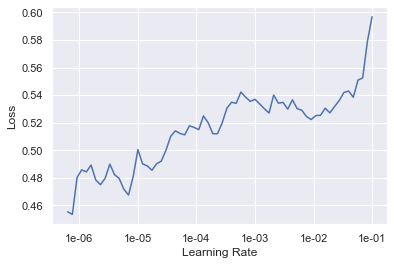

In [79]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [82]:
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.524347,0.535075,0.797473,22:33
1,0.500195,0.533918,0.797131,24:23
2,0.482698,0.534367,0.797473,32:36
3,0.436441,0.528534,0.801913,28:38
4,0.430478,0.535348,0.800888,21:24


We see that we have achieved maximum accuracy of 80% by the end of this model.

In [104]:
learn.save('fwd_clas')

For our final results, we'll take the average of the predictions of the model. Since the samples are sorted by text lengths for batching, we pass the argument ordered=True to get the predictions in the order of the texts.

In [84]:
pred_fwd,lbl_fwd = learn.get_preds(ordered=True)

In [86]:
accuracy(pred_fwd, lbl_fwd)

tensor(0.8009)

We got the accuracy of 80.09%

Now it's time to test our model with new text inputs & see how it performs!

The databunch has converted the text labels into numericals. They are as follows:

* 0 => Negative 
* 1 => Neutral
* 2 => Positive

In [105]:
learn.predict("United Airways sucks big time!")

c:\users\sai\appdata\local\programs\python\python37\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(2), tensor(2), tensor([0.2381, 0.0982, 0.6636]))

In [109]:
learn.predict("I love traveling with Vistara Airways!!!!  Awesome service.. Thank you!!")

c:\users\sai\appdata\local\programs\python\python37\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(2), tensor(2), tensor([0.0057, 0.0076, 0.9867]))

In [110]:
learn.predict("The customer service of American Airlines flight is terrible. I am having such a bad day!!! ugghh")

c:\users\sai\appdata\local\programs\python\python37\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category tensor(0), tensor(0), tensor([0.7716, 0.0128, 0.2156]))

We see that our model has performed pretty well!!

## Final Comments

Although the model did pretty good job & we got the accuracy of around 80%, there's still room for the improvement. We can do hyperp-parameter tuning of training our model with a bunch of learning rates to find the optimal.